#### **<u>Apply ESN to CESM </u>**

**Tech Preamble**

In [74]:
import glob
from netCDF4 import Dataset
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr

# import warnings
# warnings.filterwarnings("ignore")

#### **Step 1 - Select Area**

load **one** Dataset and find indices

In [75]:
original_file_path = "/data/ocean/CESM_output/GCS_2015_2017/ctrl_ocn/ctrl.g.e11.G.T62_t12.002.pop.h.0022-08.nc"
original_ds = xr.open_dataset(original_file_path)

/tmp/ipykernel_843467/3742792802.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  original_ds = xr.open_dataset(original_file_path)


**Example: Kuroshio**

In [64]:
# --- Change to Coordinates of desired region ---
lat_min, lat_max = 25, 40
lon_min, lon_max = 125, 150 

lat = original_ds['TLAT']
lon = original_ds['TLONG']

lat_indices = np.where((lat >= lat_min) & (lat <= lat_max))[0]
lon_indices = np.where((lon >= lon_min) & (lon <= lon_max))[1]

print(f"Latitude indices min: {lat_indices.min()}, max: {lat_indices.max()}")
print(f"Longitude indices min: {lon_indices.min()}, max: {lon_indices.max()}")

Latitude indices min: 1440, max: 1649
Longitude indices min: 2350, max: 2699


#### **Step 2 - Switch to TERMINAL and use nco to chunk data**

**2.1 Do it for one dataset and check**

**Example: Kuro**

<br>

_Create the output directory_

mkdir -p /data/Hannah/Kuro

<br>

_Run the ncks command with the specified latitude and longitude ranges_


ncks -4 -O \
  -d nlat,1440,1649 -d nlon,2350,2699 \
  --cnk_dmn nlat,50 --cnk_dmn nlon,50 \
  /data/ocean/CESM_output/GCS_2015_2017/ctrl_ocn/ctrl.g.e11.G.T62_t12.002.pop.h.0022-08.nc \
  /data/Hannah/Kuro/ctrl_chunked_v2.nc


In [65]:
file_path = "/data/Hannah/Kuro/ctrl_chunked_v2.nc"
chunked_ds = xr.open_dataset(file_path)

ssh = chunked_ds['SSH']

/tmp/ipykernel_843467/3374684588.py:2: FutureWarning: In a future version of xarray decode_timedelta will default to False rather than None. To silence this warning, set decode_timedelta to True, False, or a 'CFTimedeltaCoder' instance.
  chunked_ds = xr.open_dataset(file_path)


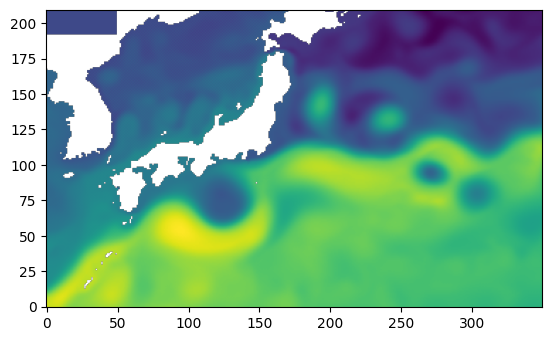

In [66]:
plt.imshow(ssh.isel(time = 0), origin = "lower")
plt.show()

**2.2 Repeat for all datasets**

**modify** and run bash script "./chunk_all_files.sh"

_this may take a copule of hours ..._


#### **Step 3 - Load chunked data**

In [67]:
file_list = sorted(glob.glob("/data/Hannah/Kuro/*.nc")) 
print((file_list))


file_list_cut = file_list[:-2]   
print((file_list_cut))


['/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-01.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-02.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-03.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-04.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-05.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-06.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-07.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-08.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-09.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-10.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-11.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0016-12.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0017-01.nc', '/data/Hannah/Kuro/chunked_ctrl.g.e11.G.T62_t12.002.pop.h.0017-02.nc', '/dat

In [86]:
ds = xr.open_mfdataset(  
    file_list_cut,  
    combine="by_coords",
    engine="netcdf4",  
    decode_timedelta=True,
)

In [88]:
ssh = ds['SSH']

Extract numpy files for ESN

In [94]:
ssh_val = ssh.values

Double-Check that the data looks sensible

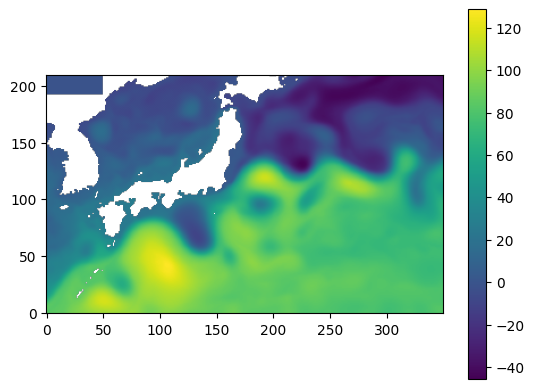

In [113]:
plt.imshow(ssh.isel(time=0), origin="lower")
plt.colorbar()
plt.show()

Set NaNs to zero bc ESN can't handle it otherwise

<br> _I am actually not quite sure that is a good idea ..._

In [99]:
ssh_concat_no_nans = np.nan_to_num(ssh_val, nan=0.0)


Double-check it's really empty 

In [100]:
print(f"Are there any NaNs left? {np.isnan(ssh_concat_no_nans).any()}")

Are there any NaNs left? False


#### **Step 4 - Read Data into ESN**

**Step 4.1 Load ESN**

In [29]:
from SWE_predict import train_and_predict_2d

**Step 4.2 Modify Input**

In [109]:
def test_SWE(savedir):
    # Spatial resolution
    input_shape = (ssh_concat_no_nans.shape[1], ssh_concat_no_nans.shape[2])
    
    # flattened out dimension
    input_size  = input_shape[0] * input_shape[1]
    
    Ntrain = 50
    Npred = 24
    Ntrans = 5

    N = Npred+Ntrain+1
    
  
    data = ssh_concat_no_nans

    k = 0.5 #changed!

    specs = [
        {"type":"pixels", "size":(input_shape[0],input_shape[1]), "factor": k},
        #{"type":"conv", "size":(3,3),   "kernel":"gauss",  "factor": k},
        #{"type":"conv", "size":(5,5),   "kernel":"gauss",  "factor": k},
        #{"type":"conv", "size":(7,7),   "kernel":"gauss",  "factor": k},
        #{"type":"conv", "size":(9,9),   "kernel":"gauss",  "factor": k},
        # {"type":"conv", "size":(3,3),   "kernel":"random", "factor": k},
        {"type":"conv", "size":(5,5),   "kernel":"random", "factor": k},
        #{"type":"conv", "size":(7,7),   "kernel":"random", "factor": k},
        # {"type":"conv", "size":(9,9),   "kernel":"random", "factor": k},
        {"type":"gradient", "factor": k},
        {"type":"dct", "size":(30,30), "factor": k},
        #{"type":"random_weights", "input_size":input_size, "hidden_size":10000, "factor": 2.},
        # {"type":"vorticity", "factor": k},

    ]
    
    parameter_dict = dict(
        specs = specs,
        Npred  = Npred,
        Ntrain = Ntrain,
        Ntrans = Ntrans,
        spectral_radius = 0.98,
        neuron_connections = 100,
        n_PCs  = 350, #changed!
        sigma  =  (0.2,0.1,0.1), #changed!
        eps    =  1e-2,
        plot_prediction = True,
        dtype='float32', #changed!
        lstsq_method ='svd',
        lstsq_thresh = 1e-3,
        ST_method = 'DCT',
        cpus_to_use = 32,
        scale_min = -1,
        scale_max =  1,
        savedir = savedir,
        neuron_dist = 'normal',
        upper_sr_calc_dim=5000,
        save_condition = 'always',
        random_seed = np.random.seed(),
        
    )

    return train_and_predict_2d(data,config=parameter_dict, **parameter_dict)

**Step 4.3 Run ESN**

Image shape is (210, 350)
Data is taking up 0.0GB. Deleting after splitting.
Starting pre-processing...
imed module was loaded from /home/hmelzer/work/imed/imed/__init__.py
Performing IMED forward transform to blurry space
IMED transform called with volume shape (50, 210, 350) and method DCT
Performing the IMED ST over axis 1
Performing the IMED ST over axis 2


IMED forward transform complete
Training set branch
imed module was loaded from /home/hmelzer/work/imed/imed/__init__.py
Performing IMED forward transform to blurry space
IMED transform called with volume shape (45, 210, 350) and method DCT
Performing the IMED ST over axis 0
Performing the IMED ST over axis 1
Performing the IMED ST over axis 2
IMED forward transform complete
val/test set branch
imed module was loaded from /home/hmelzer/work/imed/imed/__init__.py
Performing IMED forward transform to blurry space
IMED transform called with volume shape (24, 210, 350) and method DCT
Performing the IMED ST over axis 0
Performing the IMED ST over axis 1
Performing the IMED ST over axis 2
IMED forward transform complete
val/test set branch
Finished pre-processing!
Starting Building Dyn. Sys. ...
Input size (1 slice): (210, 350)
Hidden size: 294900
Using 100 nonzeros per row and uniform distribution
Building Whh took 4.76s
Starting transient Evolution of dyn. sys. ...
Transient evolution of d

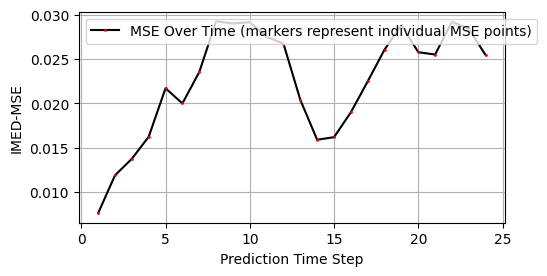

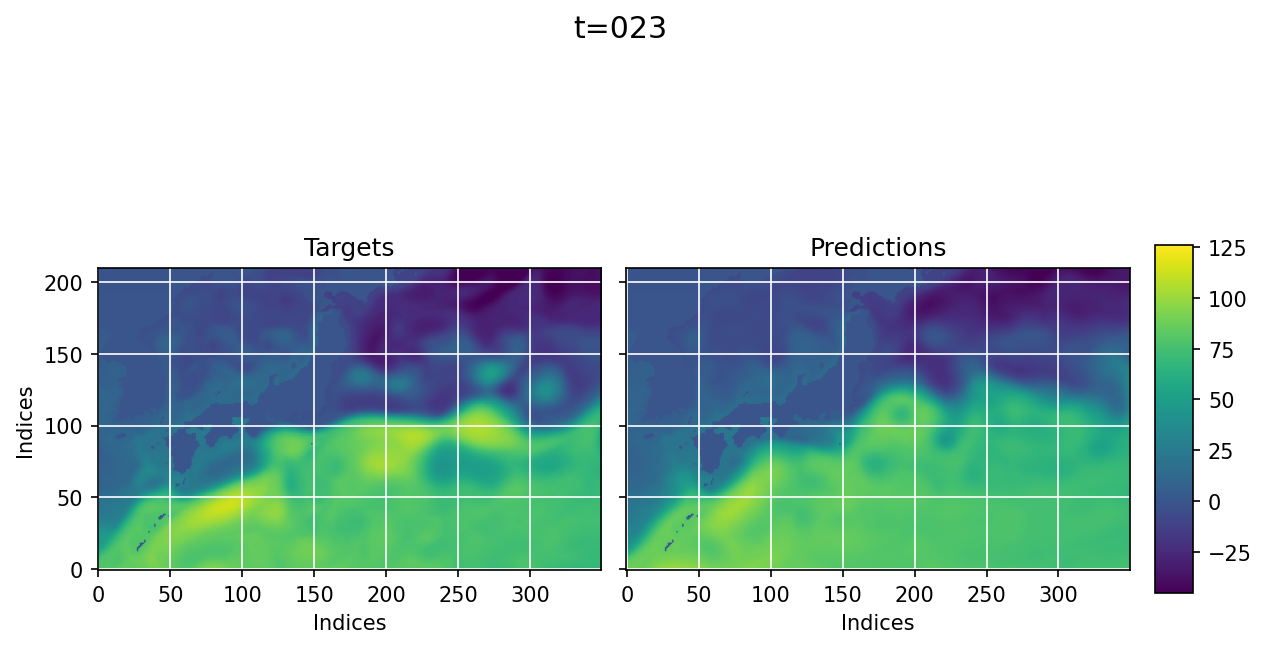

In [110]:
mse = test_SWE("CESM")